## Machine Learning

### Importação de bibliotecas

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [29]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

### ElasticNet

In [31]:
# Variáveis categóricas
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"] # Coluna categórica que não está ordenada

coluna_ordinal_encoder = ["median_income_cat"] # Coluna categorica que já está ordenada

In [32]:
# Variáveis numéricas
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder) # Colunas com outliers

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [33]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # Transformador menos sensíveis a outiliers
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # Polinômio de grau 1
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder), # Coluna categorica que já está ordenada
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder), # Coluna categórica que não está ordenada
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler), # Transformador menos sensíveis a outiliers e com polinômio
    ],
)

In [34]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [35]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [36]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


### Melhor parâmetro

In [37]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3], # Busca melhor grau de polinômio
    "regressor__reg__alpha": [0.01, 0.05, 0.1, 0.25, 0.5, 1.0], # Busca melhor alpha
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9], # Busca melhor l1_ratio
}

In [38]:
# Avaliando o modelo de regressão linear
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(), 
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"), # Melhor transformador de target
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [39]:
# Ajustando o modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\lsgal\miniconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+02, tolerance: 1.765e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [40]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

- Alpha e l1_ratio pequenos, indicando que o modelo está mais pro Ridge do que Lasso
- Obs: ElasticNet é uma junção de Ridge e Lasso, e se os parâmetros forem mais próximos de 1, o caminho é o Lasso, caso contrário, Ridge

In [41]:
grid_search.best_score_

np.float64(-51293.75005713282)

Comparado ao modelo de LinearRegression Polinomial, teve um score menor, sendo melhor usar o modelo polinomial do LinearRegression, a principio

In [42]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.598411
robust_scaler_poly__longitude,-0.379468
robust_scaler_poly__population_per_household,-0.341300
robust_scaler_poly__latitude,-0.212244
robust_scaler_poly__latitude^2,-0.192847
...,...
ordinal_encoder__median_income_cat,0.092153
robust_scaler_poly__housing_median_age longitude^2,0.108315
robust_scaler_poly__bedrooms_per_room,0.129575
robust_scaler_poly__housing_median_age median_income,0.179935


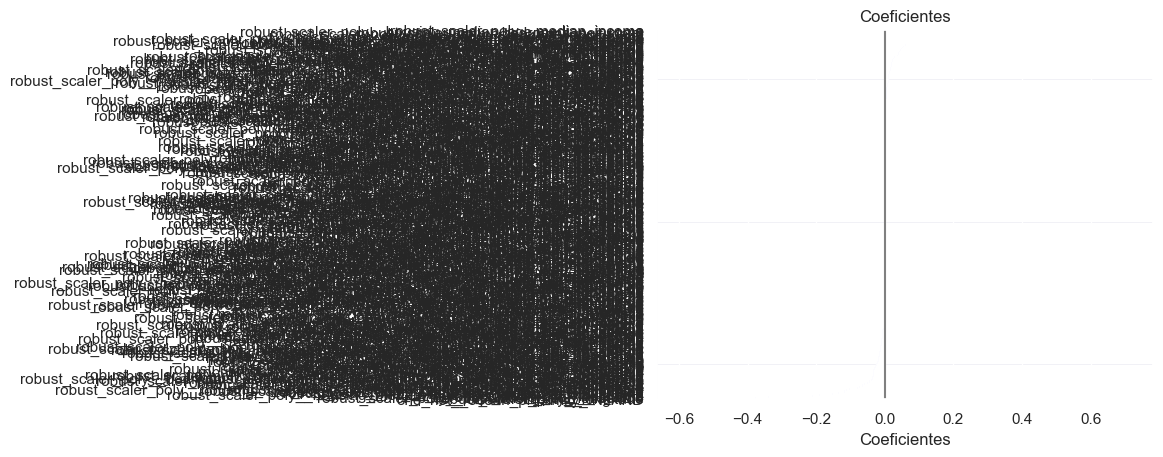

In [43]:
plot_coeficientes(coefs)

In [44]:
coefs[coefs["coeficiente"] == 0]

,coeficiente
robust_scaler_poly__bedrooms_per_room population_per_household,-0.0
robust_scaler_poly__population_per_household total_rooms^2,0.0
robust_scaler_poly__total_rooms^3,0.0
robust_scaler_poly__total_rooms,0.0
robust_scaler_poly__total_bedrooms total_rooms^2,0.0
...,...
robust_scaler_poly__median_income rooms_per_household total_bedrooms,-0.0
robust_scaler_poly__bedrooms_per_room housing_median_age total_bedrooms,-0.0
robust_scaler_poly__longitude population rooms_per_household,0.0
robust_scaler_poly__longitude population population_per_household,-0.0


In [45]:
# Coeficientes com valores entre -0.1 e 0.1, diferentes de 0
coefs[coefs["coeficiente"].between(-0.1, 0.1) & (coefs["coeficiente"] != 0)]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.082456
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.075313
robust_scaler_poly__housing_median_age latitude,-0.067452
robust_scaler_poly__median_income^2,-0.065902
robust_scaler_poly__median_income population_per_household,-0.061683
...,...
robust_scaler_poly__total_bedrooms,0.075189
robust_scaler_poly__housing_median_age population_per_household^2,0.084869
robust_scaler_poly__housing_median_age,0.087265
robust_scaler_poly__median_income total_bedrooms,0.091748


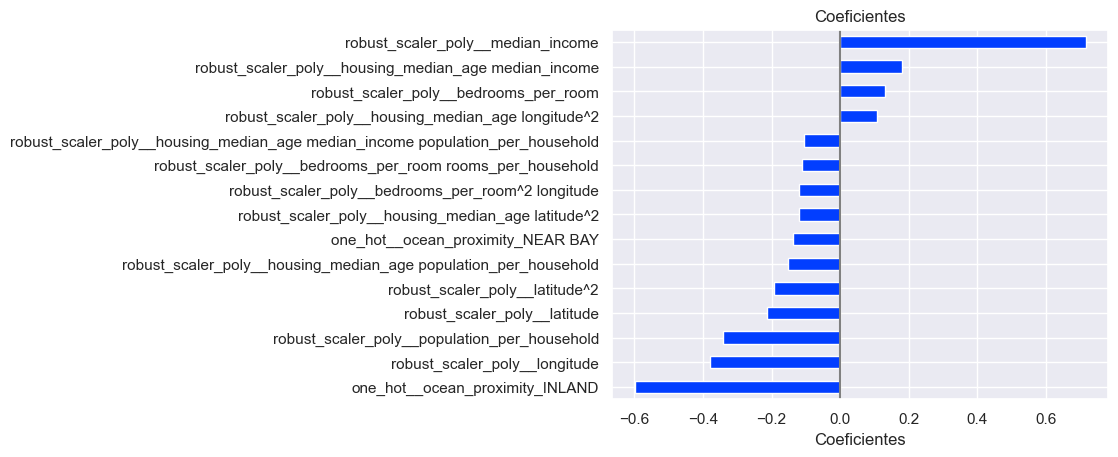

In [46]:
# Coeficientes que não estão entre -0.1, 0.1
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.1, 0.1)])

Renda (median_income) retornou como maior coeficiente, tendo maior peso pra explicar o modelo. Além das features de idade da casa com renda e quartos por cômodos. Mesmo tendo um score menor que o LinearRegression polinomial, é mais fácil de explicar o modelo com as features

In [47]:
regressors = {
    # DummyRegressor
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    # LinearRegression sem target transformado
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    # LinearRegression com target transformado
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    # Melhor modelo
    "ElasticNet_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [48]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\lsgal\miniconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e+01, tolerance: 1.430e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\lsgal\miniconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e+01, tolerance: 1.451e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\lsgal\miniconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00399,0.003683,-0.000081,-77516.042766,-96239.705692,0.007673
1,DummyRegressor,0.003029,0.002991,-0.000146,-75787.787194,-95217.629397,0.006019
2,DummyRegressor,0.002993,0.003029,-0.001737,-76753.598961,-96253.253947,0.006022
3,DummyRegressor,0.002957,0.003177,-0.000101,-76837.804811,-95983.885799,0.006134
4,DummyRegressor,0.002994,0.002801,-0.000114,-76617.245449,-96182.764729,0.005796
5,LinearRegression,0.025706,0.010527,0.682162,-39855.690996,-54254.958188,0.036232
6,LinearRegression,0.025004,0.008975,0.66999,-40272.565467,-54695.230283,0.033979
7,LinearRegression,0.02968,0.008976,0.649247,-42178.05929,-56955.988706,0.038656
8,LinearRegression,0.028616,0.00997,0.669873,-40806.492497,-55146.318803,0.038586
9,LinearRegression,0.032396,0.01182,0.669023,-40788.496497,-55331.35106,0.044217


In [49]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003192,0.003136,-0.000436,-76702.495836,-95975.447913,0.006329
ElasticNet_grid_search,5.627033,0.022562,0.713923,-35998.791827,-51304.615481,5.649595
LinearRegression,0.028281,0.010054,0.668059,-40780.26095,-55276.769408,0.038334
LinearRegression_target,0.045832,0.014137,0.678233,-38672.960076,-54419.64128,0.059969


In [50]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003192,0.003136,-0.000436,-76702.495836,-95975.447913,0.006329
LinearRegression,0.028281,0.010054,0.668059,-40780.26095,-55276.769408,0.038334
LinearRegression_target,0.045832,0.014137,0.678233,-38672.960076,-54419.64128,0.059969
ElasticNet_grid_search,5.627033,0.022562,0.713923,-35998.791827,-51304.615481,5.649595


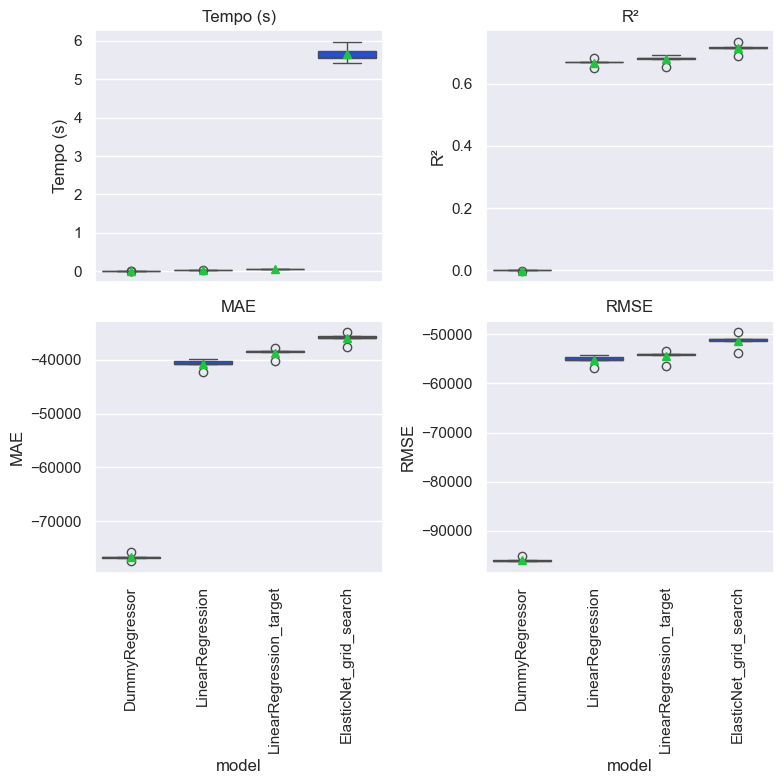

In [51]:
plot_comparar_metricas_modelos(df_resultados)

- Tempo: grid search (elasticnet) está levando um tempo maior de 7x em relação ao LinearRegression
- R2, MAE, RMSE: grid search (elasticnet) melhora um pouco as métricas que o LinearRegression
- É melhor usar o grid search (elasticnet) que o LinearRegression

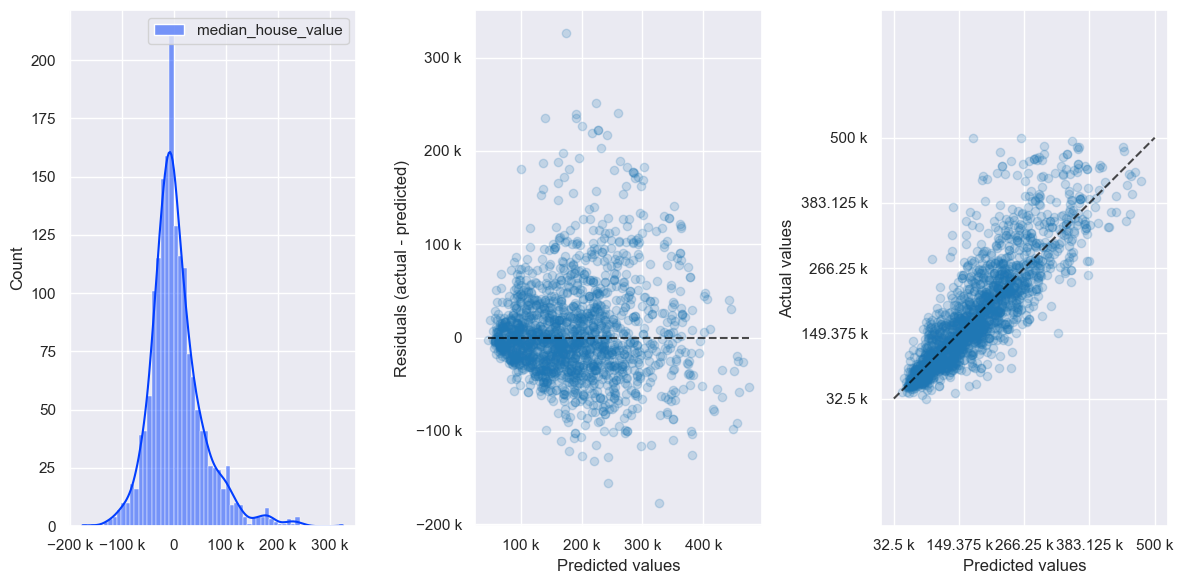

In [52]:
# Plota gráfico de resíduos com melhor modelo, usando 10% dos dados e com formatação de abreviação dos números
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

Pegando 10% dos dados e comparando os dados reais com os dados do melhor estimador de modelo (ElasticNet):
- Percebe-se que uma parte significativa dos pontos estão próximos da reta no gráfico de resíduos (2), fazendo que o modelo tenha menos erros
- Possue mais erros positivos que negativos, sendo observado tanto pelo histograma (1) com a cauda mais alongada para os valores positivos e o gráfico de dispersão de resíduos (2) com mais valores acima da reta que abaixo da reta